In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import resnet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_fullver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'train_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_train_FNs.npy'))
    return images, labels, filenames


def load_testing():
    images = np.load(os.path.join('../Data_final_fullver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_fullver', 'test_labels1_num.npy'))
    filenames = np.load(os.path.join('../Data_final_fullver', 'CBIS_test_FNs.npy'))
    return images, labels, filenames

In [3]:
train_images, train_labels, Fn= load_training()
test_images, test_labels, Fn= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2925 	 Test size: 643
Image size: 256x256


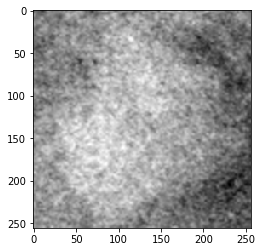

Label: 1
FN: Mass-Training_P_00106_LEFT_CC.png


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
print("FN: " + str(Fn[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(2925, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_resnet50(verbose=False, fc_size=256, output = 2, dropout=None):
    
    from tensorflow.keras.applications import resnet50
    
    resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet50 = models.Sequential()
    resnet50.add(resnet50_base)

    resnet50.add(layers.Flatten())
    if dropout is not None:
        resnet50.add(layers.Dropout(dropout))
    resnet50.add(layers.Dense(fc_size, activation='relu'))
    resnet50.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    resnet50_base.trainable = False
    
    if verbose:
        resnet50_base.summary()
        resnet50.summary()

    return resnet50

In [12]:
resnet = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in resnet.layers:
    layer.trainable = False
resnet_maxpool = resnet.get_layer('conv5_block3_out').output
FeatureFlatten = Flatten()(resnet_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_resnet = Model(inputs = resnet.input, outputs = predictions)
new_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
resnet50_calc_or_mass_best_Adam = new_resnet

In [14]:
resnet50_calc_or_mass_best_RMSprop = new_resnet

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet50_calc_or_mass_best_Adam = resnet50_calc_or_mass_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 3.5182 - recall: 0.5404
Epoch 00001: val_loss improved from inf to 0.60903, saving model to ../model/resnet50_calc_or_mass_best_Adam.h5
11/11 [==============================] - 27s 2s/step - loss: 3.2685 - recall: 0.5464 - val_loss: 0.6090 - val_recall: 0.6188
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5610 - recall: 0.7320
Epoch 00002: val_loss improved from 0.60903 to 0.58368, saving model to ../model/resnet50_calc_or_mass_best_Adam.h5
11/11 [==============================] - 25s 2s/step - loss: 0.5473 - recall: 0.7401 - val_loss: 0.5837 - val_recall: 0.7145
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4633 - recall: 0.7898
Epoch 00003: val_loss improved from 0.58368 to 0.55529, saving model to ../m

10/11 [==========================>...] - ETA: 1s - loss: 0.3328 - recall: 0.8426
Epoch 00027: val_loss did not improve from 0.40510
11/11 [==============================] - 21s 2s/step - loss: 0.3398 - recall: 0.8457 - val_loss: 0.4226 - val_recall: 0.7983
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3458 - recall: 0.8492
Epoch 00028: val_loss did not improve from 0.40510
11/11 [==============================] - 21s 2s/step - loss: 0.3448 - recall: 0.8501 - val_loss: 0.4474 - val_recall: 0.7915
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.3349 - recall: 0.8523
Epoch 00029: val_loss did not improve from 0.40510
11/11 [==============================] - 21s 2s/step - loss: 0.3293 - recall: 0.8565 - val_loss: 0.4764 - val_recall: 0.7726
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.2899 - recall: 0.8704
Epoch 00030: val_loss did not improve from 0.40510
11/11 [==============================] - 20s 2s/step - los

In [17]:
models.save_model(resnet50_calc_or_mass_best_Adam, '../model/resnet50_calc_or_mass_end_Adam.h5')

In [18]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adam.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adam.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adam.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adam.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 52
Epoch [opt]: 22
Valid recall [end]: 0.8051
Valid recall [opt]: 0.8120
Test recall [end]:  0.8072
Test recall [opt]:  0.8087
Valid loss [end]: 0.4286
Valid loss [opt]: 0.4051
Test loss [end]:  0.4445
Test loss [opt]:  0.4147


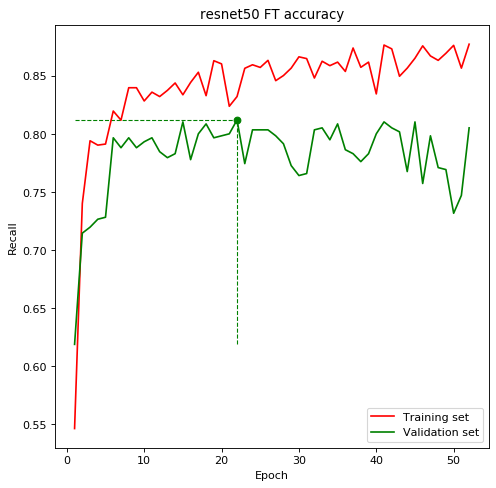

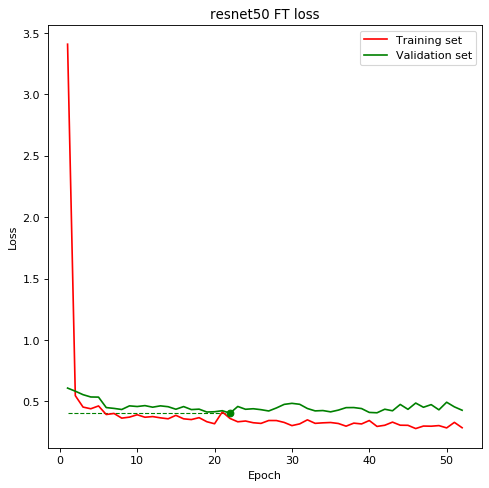

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [14]:
resnet50_calc_or_mass_best_SGD = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [15]:
# Train
history_resnet50_calc_or_mass_best_SGD = resnet50_calc_or_mass_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3922 - recall: 0.5156
Epoch 00001: val_loss improved from inf to 1.06069, saving model to ../model/resnet50_calc_or_mass_best_SGD.h5
11/11 [==============================] - 25s 2s/step - loss: 1.3932 - recall: 0.5192 - val_loss: 1.0607 - val_recall: 0.4974
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2527 - recall: 0.5562
Epoch 00002: val_loss improved from 1.06069 to 0.97004, saving model to ../model/resnet50_calc_or_mass_best_SGD.h5
11/11 [==============================] - 23s 2s/step - loss: 1.2642 - recall: 0.5490 - val_loss: 0.9700 - val_recall: 0.5197
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1407 - recall: 0.5657
Epoch 00003: val_loss did not improve from 0.97004
11/11 [====================

Epoch 27/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7744 - recall: 0.6726
Epoch 00027: val_loss did not improve from 0.64233
11/11 [==============================] - 21s 2s/step - loss: 0.7635 - recall: 0.6786 - val_loss: 0.6545 - val_recall: 0.6530
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6803 - recall: 0.7155
Epoch 00028: val_loss did not improve from 0.64233
11/11 [==============================] - 20s 2s/step - loss: 0.6920 - recall: 0.7044 - val_loss: 0.6553 - val_recall: 0.6393
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7104 - recall: 0.6906
Epoch 00029: val_loss did not improve from 0.64233
11/11 [==============================] - 21s 2s/step - loss: 0.7175 - recall: 0.6882 - val_loss: 0.6591 - val_recall: 0.6547
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.6913 - recall: 0.6936
Epoch 00030: val_loss did not improve from 0.64233
11/11 [==============================] - 21s 

Epoch 85/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5512 - recall: 0.7685
Epoch 00085: val_loss did not improve from 0.52683
11/11 [==============================] - 21s 2s/step - loss: 0.5610 - recall: 0.7622 - val_loss: 0.6036 - val_recall: 0.7077
Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5365 - recall: 0.7416
Epoch 00086: val_loss did not improve from 0.52683
11/11 [==============================] - 22s 2s/step - loss: 0.5315 - recall: 0.7485 - val_loss: 0.5959 - val_recall: 0.6906
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5760 - recall: 0.7359
Epoch 00087: val_loss did not improve from 0.52683
11/11 [==============================] - 22s 2s/step - loss: 0.5621 - recall: 0.7378 - val_loss: 0.5566 - val_recall: 0.7265
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5603 - recall: 0.7399
Epoch 00088: val_loss improved from 0.52683 to 0.51584, saving model to ../model/resnet50_calc_o

10/11 [==========================>...] - ETA: 1s - loss: 0.5040 - recall: 0.7586
Epoch 00115: val_loss did not improve from 0.51584
11/11 [==============================] - 22s 2s/step - loss: 0.5133 - recall: 0.7576 - val_loss: 0.5188 - val_recall: 0.7179
Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 0.5182 - recall: 0.7483
Epoch 00116: val_loss did not improve from 0.51584
11/11 [==============================] - 29s 3s/step - loss: 0.5213 - recall: 0.7485 - val_loss: 0.5614 - val_recall: 0.7179
Epoch 117/300
10/11 [==========================>...] - ETA: 1s - loss: 0.4971 - recall: 0.7727
Epoch 00117: val_loss did not improve from 0.51584
11/11 [==============================] - 24s 2s/step - loss: 0.4886 - recall: 0.7805 - val_loss: 0.5529 - val_recall: 0.7248
Epoch 118/300
10/11 [==========================>...] - ETA: 5s - loss: 0.5004 - recall: 0.7652
Epoch 00118: val_loss did not improve from 0.51584
11/11 [==============================] - 83s 8s/step - 

In [16]:
models.save_model(resnet50_calc_or_mass_best_SGD, '../model/resnet50_calc_or_mass_end_SGD.h5')

In [17]:
tra_loss_fe = history_resnet50_calc_or_mass_best_SGD.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_SGD.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_SGD.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_SGD.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 calc or mass

Epoch [end]: 118
Epoch [opt]: 88
Valid recall [end]: 0.7145
Valid recall [opt]: 0.7419
Test recall [end]:  0.7263
Test recall [opt]:  0.7030
Valid loss [end]: 0.5654
Valid loss [opt]: 0.5158
Test loss [end]:  0.5582
Test loss [opt]:  0.5821


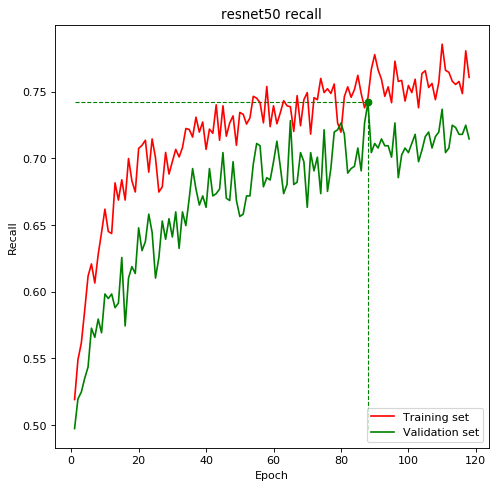

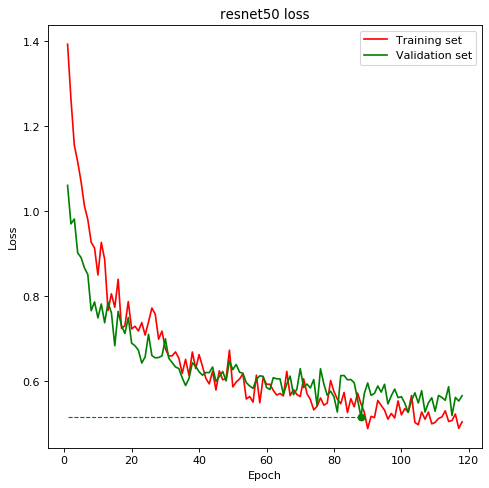

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_resnet50_calc_or_mass_best_RMSprop = resnet50_calc_or_mass_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
 1/11 [=>............................] - ETA: 53sWARNING:tensorflow:Can save best model only with val_loss available, skipping.


UnknownError: 2 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv1_conv/Conv2D (defined at <ipython-input-16-0f2262146e6e>:10) ]]
	 [[metrics/recall/assert_less_equal/Assert/AssertGuard/pivot_f/_13/_37]]
  (1) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv1_conv/Conv2D (defined at <ipython-input-16-0f2262146e6e>:10) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_11997]

Function call stack:
distributed_function -> distributed_function


In [ ]:
models.save_model(resnet50_calc_or_mass_best_RMSprop, '../model/resnet50_calc_or_mass_end_RMSprop.h5')

In [ ]:
tra_loss_fe = history_resnet50_calc_or_mass_best_RMSprop.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_RMSprop.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_RMSprop.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_RMSprop.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [ ]:
resnet50_calc_or_mass_best_Adadelta = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [ ]:
# Train
history_resnet50_calc_or_mass_best_Adadelta = resnet50_calc_or_mass_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

In [ ]:
models.save_model(resnet50calc_or_mass_best_Adadelta, '../model/resnet50_calc_or_mass_end_Adadelta.h5')

In [ ]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adadelta.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adadelta.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adadelta.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adadelta.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [ ]:
resnet50_calc_or_mass_best_Adagrad = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [ ]:
# Train
history_resnet50_calc_or_mass_best_Adagrad = resnet50_calc_or_mass_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

In [ ]:
models.save_model(resnet50_calc_or_mass_best_Adagrad, '../model/resnet50_calc_or_mass_end_Adagrad.h5')

In [ ]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adagrad.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adagrad.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adagrad.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adagrad.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [ ]:
resnet50_calc_or_mass_best_Adamax = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [ ]:
# Train
history_resnet50_calc_or_mass_best_Adamax = resnet50_calc_or_mass_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

In [ ]:
models.save_model(resnet50_calc_or_mass_best_Adamax, '../model/resnet50_calc_or_mass_end_Adamax.h5')

In [ ]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Adamax.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Adamax.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Adamax.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Adamax.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [ ]:
resnet50_calc_or_mass_best_Nadam = create_resnet50(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/resnet50_calc_or_mass_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

resnet50_calc_or_mass_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [ ]:
# Train
history_resnet50_calc_or_mass_best_Nadam = resnet50_calc_or_mass_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

In [ ]:
models.save_model(resnet50_calc_or_mass_best_Nadam, '../model/resnet50_calc_or_mass_end_Nadam.h5')

In [ ]:
tra_loss_fe = history_resnet50_calc_or_mass_best_Nadam.history['loss']
tra_acc_fe = history_resnet50_calc_or_mass_best_Nadam.history['recall']
val_loss_fe = history_resnet50_calc_or_mass_best_Nadam.history['val_loss']
val_acc_fe = history_resnet50_calc_or_mass_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_resnet50_calc_or_mass = models.load_model('../model/resnet50_calc_or_mass_best_Nadam.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass.evaluate(test_images, test_labels, verbose=False)

print("resnet50 calc or mass\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [ ]:
resnet50_calc_or_mass_fine_Adam = models.load_model('../model/resnet50_calc_or_mass_best_Adam.h5')

for layer in resnet50_calc_or_mass_fine_Adam.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_or_mass_fine_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_or_mass_fine_Adam.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_or_mass_fine_Adam_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = resnet50_calc_or_mass_fine_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(resnet50_calc_or_mass_fine_Adam, '../model/resnet50_calc_or_mass_fine_Adam_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_or_mass_fine_Adam = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass_fine_Adam.evaluate(test_images, test_labels, verbose=False)

print("resnet50 recall Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
resnet50_calc_or_mass_fine_Adam2 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best.h5')

for layer in resnet50_calc_or_mass_fine_Adam2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_or_mass_fine_Adam2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_or_mass_fine_Adam.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_or_mass_fine_Adam_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = resnet50_calc_or_mass_fine_Adam2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(resnet50_calc_or_mass_fine_Adam2, '../model/resnet50_calc_or_mass_fine_Adam_end2.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_or_mass_fine_Adam2 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best2.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass_fine_Adam2.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
resnet50_calc_or_mass_fine_Adam3 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best2.h5')

for layer in resnet50_calc_or_mass_fine_Adam3.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
resnet50_calc_or_mass_fine_Adam3.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

resnet50_calc_or_mass_fine_Adam3.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/resnet50_calc_or_mass_fine_Adam_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [ ]:
history_fit = resnet50_calc_or_mass_fine_Adam3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
models.save_model(resnet50_calc_or_mass_fine_Adam3, '../model/resnet50_calc_or_mass_fine_Adam_end3.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_calc_or_mass_fine_Adam3 = models.load_model('../model/resnet50_calc_or_mass_fine_Adam_best3.h5')
test_loss_fe, test_acc_fe = resnet50_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_calc_or_mass_fine_Adam3.evaluate(test_images, test_labels, verbose=False)

print("resnet50 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();